In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set()

In [2]:
wvs = pd.read_csv('wvs.csv.bz2', sep = '\t')
wvs.head()

,V2,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,MN_228S8,MN_229A,MN_230A,MN_233A,MN_237B1,MN_249A1,MN_249A3,I_RELIGBEL,I_NORM1,I_VOICE1
0,12,1,1,1,-2,1,1,2,1,1,...,3,-3,-3,-3,-3,1,1,0.0,1.0,0.00
1,12,1,2,3,4,2,2,2,2,2,...,3,-3,-3,-3,-3,2,-1,0.0,1.0,0.66
2,12,1,3,2,4,2,1,2,2,2,...,4,1,1,2,-3,1,1,0.0,1.0,0.33
3,12,1,1,3,4,3,1,2,1,2,...,2,2,1,2,-3,1,2,0.0,1.0,0.00
4,12,1,1,1,2,1,1,1,3,2,...,2,2,1,2,-3,1,2,0.0,1.0,0.66


## 1.1

In [3]:
wvs.shape

(90350, 328)

The dataset has 328 variables and ~90k observations.

## 1.2

In [4]:
wvs.V204.describe()

count    90350.000000
mean         2.946386
std          2.964040
min         -5.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: V204, dtype: float64

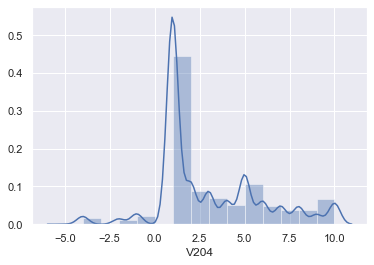

In [5]:
sns.distplot(wvs.V204, bins = 15, kde = True)

In [130]:
print("The abortion column has", wvs[wvs.V204 > 0].count().V204, "non-missing responses")

The abortion column has 85742 non-missing responses


## 1.3

In [42]:
wvs1 = wvs[wvs.V204 > 0].reset_index()# Removing the the obs that has negative values in V204
wvs1 = wvs1.drop('index', axis = 1)
wvs1.shape

(85742, 328)

In [43]:
wvs1 = wvs1.dropna() # dropping the observations that has missing values
wvs1.shape

(79267, 328)

## 1.4

In [44]:
# Creating the binary variable abortion
wvs1['abortion'] = (wvs1.V204 > 3).astype(int)
wvs1.shape

(79267, 329)

## 1.5

In [33]:
corr_matrix = wvs1.corr(method = 'pearson')

In [34]:
corr_matrix['abortion'].sort_values(ascending = False).head(10)

abortion    1.000000
V204        0.881048
V205        0.548653
V203        0.485419
V206        0.446394
V207        0.418271
V9          0.314117
V203A       0.291576
V146        0.272220
V210        0.257035
Name: abortion, dtype: float64

In [35]:
corr_matrix['abortion'].sort_values(ascending = False).tail(10)

V217   -0.117946
V106   -0.121063
V107   -0.134199
V222   -0.140166
V132   -0.140972
V138   -0.142894
V255   -0.149844
V223   -0.165924
V252   -0.191483
V152   -0.315280
Name: abortion, dtype: float64

In [45]:
# Dropping the highly correlated variables to exclude the bias
# Considering the variables that has correlation > |0.5|
wvs1 = wvs1.drop(['V204', 'V205'], axis = 1) #V204 - abortion, V205 - divorce
wvs1.shape

(79267, 327)

## 1.6

In [46]:
wvs1 = wvs1.rename(columns = {'V2': 'country'})

In [47]:
wvs1 = pd.get_dummies(wvs1, columns = ['country']) # Creating the dummy variables for the countries

In [48]:
wvs1.head()

,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,country_752,country_764,country_780,country_788,country_792,country_804,country_840,country_858,country_860,country_887
0,1,1,1,-2,1,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2,3,4,2,2,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2,4,2,1,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,1,1,3,4,3,1,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,2,1,1,1,3,2,1,...,0,0,0,0,0,0,0,0,0,0


In [49]:
wvs1 = wvs1.drop('country_887', axis = 1)
wvs1.shape

(79267, 383)

## 2. Implement k-Cross Fold validation

In [136]:
def kfold_cross_val(k, clf, X, y):
    # Shuffle Indices
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(X))
    X = X[shuffled_indices]
    y = y[shuffled_indices]
    
    # Splitting predictors and predictands into k folds
    X_split = np.array_split(X, k)
    y_split = np.array_split(y, k)
    
    # Intializing the classification scores
    f1_score_sum = 0
    accuracy_sum = 0
    precision_sum = 0
    recall_sum = 0
    
    for i in range(k):
        X_train = X_split.copy() # Creating a copy of the predictors
        X_valid = X_split[i]     # Validation predictors
        y_train = y_split.copy() # Copy of the target
        y_valid = y_split[i]     # Validation target
        del X_train[i]           # Deleting the validation predictors from the training
        del y_train[i]           # Deleting the validation target from the training
        
        # Concatenate the folds into single array
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        
        # Performing the model and getting classification scores after each iteration
        f1, acc, prec, rec = perform(i, clf, X_train, y_train, X_valid, y_valid)
        
        # Summing the classification scores after each iteration
        f1_score_sum = f1_score_sum + f1
        accuracy_sum = accuracy_sum + acc
        precision_sum = precision_sum + prec
        recall_sum = recall_sum + rec
    
    print("Average f1-score:", round((f1_score_sum/k), 2))
    print("Average accuracy:", round((accuracy_sum/k), 2))
    print("Average precision:", round((precision_sum/k), 2))
    print("Average recall:", round((recall_sum/k), 2))

In [137]:
def perform(a, clf, X_train, y_train, X_valid, y_valid):
    from sklearn import metrics # importing the metrics library to calculate classification scores
    clf.fit(X_train, y_train) # Fitting the model with the training data
    y_pred = clf.predict(X_valid) # Predicting the target with validation data
    
    # Calculating the scores
    f1_score = metrics.f1_score(y_valid, y_pred)
    accuracy = metrics.accuracy_score(y_valid, y_pred)
    precision = metrics.precision_score(y_valid, y_pred)
    recall = metrics.recall_score(y_valid, y_pred)
    
    print(str(a + 1), ". F1-score:", round(f1_score, 2), "\tAccuracy:", round(accuracy, 2))
    print("\tPrecision:", round(precision, 2), "\tRecall:", round(recall, 2))
    return f1_score, accuracy, precision, recall

## 3.1 knn

In [138]:
# Extracting random samples of 10k observations from the data 
wvs_work = wvs1.sample(n = 10000, random_state = 42).reset_index()
wvs_work = wvs_work.drop('index', axis = 1)

X = wvs_work.drop('abortion', axis = 1).to_numpy() # Predictors
y = wvs_work['abortion'] # Target

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# 5-fold CV with 5 neighbors
kfold_cross_val(5, knn, X, y)

1 . F1-score: 0.69 	Accuracy: 0.78
	Precision: 0.71 	Recall: 0.66
2 . F1-score: 0.67 	Accuracy: 0.77
	Precision: 0.73 	Recall: 0.62
3 . F1-score: 0.68 	Accuracy: 0.78
	Precision: 0.75 	Recall: 0.61
4 . F1-score: 0.65 	Accuracy: 0.76
	Precision: 0.69 	Recall: 0.61
5 . F1-score: 0.66 	Accuracy: 0.77
	Precision: 0.72 	Recall: 0.61
Average f1-score: 0.67
Average accuracy: 0.77
Average precision: 0.72
Average recall: 0.62


In [142]:
# 5-fold CV with 9 neighbors
knn = KNeighborsClassifier(n_neighbors = 9)
kfold_cross_val(5, knn, X, y)

1 . F1-score: 0.69 	Accuracy: 0.78
	Precision: 0.73 	Recall: 0.65
2 . F1-score: 0.67 	Accuracy: 0.78
	Precision: 0.74 	Recall: 0.61
3 . F1-score: 0.68 	Accuracy: 0.78
	Precision: 0.77 	Recall: 0.61
4 . F1-score: 0.65 	Accuracy: 0.77
	Precision: 0.71 	Recall: 0.6
5 . F1-score: 0.68 	Accuracy: 0.78
	Precision: 0.75 	Recall: 0.61
Average f1-score: 0.67
Average accuracy: 0.78
Average precision: 0.74
Average recall: 0.62


In the k-Nearest Neighbors algorithm with 5 neighbors, the average f1-score is 0.67, the accuracy is 0.77, precision is 0.72 and recall is 0.63. From the classification scores, what we can see is that the model is able to predict correctly whether someone is supporting the abortion or not 77% of the time. With the precision score we can see that the model predicts correctly whether someone is supporting the abortion 72% of the time and wrongly predicted it 28% of the time. Similarly for the recall the model predicts the people who support abortion 63% of the time.

With 9 neighbors, we could see there is a slight increase in the accuracy and precision but the model doesn't deviate much from the result of 5 negihbors classification.

## 3.2 Logistic Regression

In [140]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()

kfold_cross_val(10, logReg, X, y)

1 . F1-score: 0.76 	Accuracy: 0.83
	Precision: 0.78 	Recall: 0.74
2 . F1-score: 0.75 	Accuracy: 0.82
	Precision: 0.77 	Recall: 0.72
3 . F1-score: 0.75 	Accuracy: 0.82
	Precision: 0.79 	Recall: 0.71
4 . F1-score: 0.73 	Accuracy: 0.82
	Precision: 0.8 	Recall: 0.68
5 . F1-score: 0.77 	Accuracy: 0.82
	Precision: 0.8 	Recall: 0.74
6 . F1-score: 0.78 	Accuracy: 0.85
	Precision: 0.81 	Recall: 0.76
7 . F1-score: 0.73 	Accuracy: 0.81
	Precision: 0.77 	Recall: 0.69
8 . F1-score: 0.74 	Accuracy: 0.83
	Precision: 0.79 	Recall: 0.69
9 . F1-score: 0.72 	Accuracy: 0.81
	Precision: 0.77 	Recall: 0.68
10 . F1-score: 0.76 	Accuracy: 0.83
	Precision: 0.79 	Recall: 0.72
Average f1-score: 0.75
Average accuracy: 0.82
Average precision: 0.79
Average recall: 0.71


We could see that the logistic regression model performs better than the knn model in terms of the classification scores.

## 3.3 SVM

In [103]:
from sklearn.svm import SVC
wvs_work1 = wvs1.sample(n = 1000, random_state = 42).reset_index()
wvs_work1 = wvs_work1.drop('index', axis = 1)

X1 = wvs_work1.drop('abortion', axis = 1).to_numpy()
y1 = wvs_work1['abortion']

In [144]:
wvs_work1.groupby('abortion').size().div(len(wvs_work1))

abortion
0    0.638
1    0.362
dtype: float64

In [105]:
svc = SVC(kernel = 'linear')

kfold_cross_val(10, svc, X1, y1)

1 . F1-score: 0.6 	Accuracy: 0.75
	Precision: 0.58 	Recall: 0.63
2 . F1-score: 0.57 	Accuracy: 0.67
	Precision: 0.56 	Recall: 0.58
3 . F1-score: 0.63 	Accuracy: 0.75
	Precision: 0.62 	Recall: 0.64
4 . F1-score: 0.62 	Accuracy: 0.72
	Precision: 0.64 	Recall: 0.61
5 . F1-score: 0.61 	Accuracy: 0.7
	Precision: 0.62 	Recall: 0.59
6 . F1-score: 0.71 	Accuracy: 0.77
	Precision: 0.7 	Recall: 0.72
7 . F1-score: 0.72 	Accuracy: 0.78
	Precision: 0.74 	Recall: 0.7
8 . F1-score: 0.63 	Accuracy: 0.72
	Precision: 0.62 	Recall: 0.65
9 . F1-score: 0.69 	Accuracy: 0.77
	Precision: 0.59 	Recall: 0.84
10 . F1-score: 0.68 	Accuracy: 0.76
	Precision: 0.68 	Recall: 0.68
Average f1-score: 0.65
Average accuracy: 0.74
Average precision: 0.63
Average recall: 0.66


In [120]:
svc = SVC(kernel = 'rbf', gamma = 0.001, C = 100)
kfold_cross_val(10, svc, X1, y1)

1 . F1-score: 0.69 	Accuracy: 0.83
	Precision: 0.76 	Recall: 0.63
2 . F1-score: 0.62 	Accuracy: 0.74
	Precision: 0.7 	Recall: 0.55
3 . F1-score: 0.58 	Accuracy: 0.75
	Precision: 0.65 	Recall: 0.52
4 . F1-score: 0.72 	Accuracy: 0.81
	Precision: 0.83 	Recall: 0.63
5 . F1-score: 0.71 	Accuracy: 0.8
	Precision: 0.83 	Recall: 0.62
6 . F1-score: 0.79 	Accuracy: 0.85
	Precision: 0.85 	Recall: 0.74
7 . F1-score: 0.78 	Accuracy: 0.83
	Precision: 0.79 	Recall: 0.78
8 . F1-score: 0.7 	Accuracy: 0.79
	Precision: 0.75 	Recall: 0.65
9 . F1-score: 0.73 	Accuracy: 0.84
	Precision: 0.76 	Recall: 0.71
10 . F1-score: 0.71 	Accuracy: 0.8
	Precision: 0.76 	Recall: 0.68
Average f1-score: 0.7
Average accuracy: 0.8
Average precision: 0.77
Average recall: 0.65


In [123]:
svc = SVC(kernel = 'rbf', gamma = 0.0001)
kfold_cross_val(10, svc, X1, y1)

1 . F1-score: 0.73 	Accuracy: 0.85
	Precision: 0.8 	Recall: 0.67
2 . F1-score: 0.62 	Accuracy: 0.76
	Precision: 0.77 	Recall: 0.53
3 . F1-score: 0.69 	Accuracy: 0.82
	Precision: 0.8 	Recall: 0.61
4 . F1-score: 0.72 	Accuracy: 0.82
	Precision: 0.88 	Recall: 0.61
5 . F1-score: 0.67 	Accuracy: 0.78
	Precision: 0.81 	Recall: 0.56
6 . F1-score: 0.7 	Accuracy: 0.81
	Precision: 0.92 	Recall: 0.56
7 . F1-score: 0.79 	Accuracy: 0.85
	Precision: 0.9 	Recall: 0.7
8 . F1-score: 0.7 	Accuracy: 0.81
	Precision: 0.85 	Recall: 0.59
9 . F1-score: 0.68 	Accuracy: 0.83
	Precision: 0.82 	Recall: 0.58
10 . F1-score: 0.63 	Accuracy: 0.77
	Precision: 0.77 	Recall: 0.54
Average f1-score: 0.69
Average accuracy: 0.81
Average precision: 0.83
Average recall: 0.59


In [118]:
svc = SVC(kernel = 'sigmoid', gamma = 0.0001)
kfold_cross_val(10, svc, X1, y1)

1 . F1-score: 0.69 	Accuracy: 0.84
	Precision: 0.82 	Recall: 0.6
2 . F1-score: 0.55 	Accuracy: 0.74
	Precision: 0.8 	Recall: 0.42
3 . F1-score: 0.63 	Accuracy: 0.81
	Precision: 0.89 	Recall: 0.48
4 . F1-score: 0.66 	Accuracy: 0.8
	Precision: 0.95 	Recall: 0.5
5 . F1-score: 0.65 	Accuracy: 0.78
	Precision: 0.87 	Recall: 0.51
6 . F1-score: 0.5 	Accuracy: 0.72
	Precision: 0.82 	Recall: 0.36
7 . F1-score: 0.74 	Accuracy: 0.83
	Precision: 0.96 	Recall: 0.6
8 . F1-score: 0.66 	Accuracy: 0.8
	Precision: 0.9 	Recall: 0.51
9 . F1-score: 0.61 	Accuracy: 0.81
	Precision: 0.83 	Recall: 0.48
10 . F1-score: 0.58 	Accuracy: 0.75
	Precision: 0.77 	Recall: 0.46
Average f1-score: 0.63
Average accuracy: 0.79
Average precision: 0.86
Average recall: 0.49


The SVM sigmoid and rbf kernel models have a very good precision score but a poor recall score mainly because of the class imbalance in the dataset. There is almost 64% of people saying no to abortion and 36% saying yes. Since we have a very less positives in the sample, the models are able to predict very less false positives. But among the actual positives, why I think the models are not able to perform well is because the sample has large samples for negatives and there are high chances that the models predict the positives as negatives than the other way around. Thus, the difference between the precision and recall is mainly due to the class imbalance and we could see that in the other models too but it is too evident in the SVM models. 

## 3.4

Among the three models, I would pick the Logistic Regression model over the knn and SVM models. Logistic Regression model perform really well in terms of all the classification scores and has comparatively less difference with the precision and recall and I think the Logistic Regression model will be faster than the SVM models and it performs better and provides better results than the KNN model. So, my pick would be Logistic Regression model for this data analysis and prediction.

## 4.

In [153]:
# With countries included
wvs2 = wvs1.sample(n = 79000, random_state = 42).reset_index()
wvs2 = wvs2.drop('index', axis = 1)

X_final = wvs2.drop('abortion', axis = 1).to_numpy()
y_final = wvs2['abortion']

kfold_cross_val(5, logReg, X_final, y_final)

1 . F1-score: 0.75 	Accuracy: 0.83
	Precision: 0.8 	Recall: 0.71
2 . F1-score: 0.74 	Accuracy: 0.82
	Precision: 0.79 	Recall: 0.7
3 . F1-score: 0.74 	Accuracy: 0.82
	Precision: 0.79 	Recall: 0.7
4 . F1-score: 0.75 	Accuracy: 0.83
	Precision: 0.8 	Recall: 0.71
5 . F1-score: 0.75 	Accuracy: 0.83
	Precision: 0.79 	Recall: 0.71
Average f1-score: 0.75
Average accuracy: 0.83
Average precision: 0.79
Average recall: 0.71


The Logistic Regression model predicts whether someone supports the abortion or not 83% of the time correctly and the classification scores are similar to the previous logistic regression model that we did with a sample dataset. 

In [158]:
# Countries are excluded from the dataframe
wvs2_no_country = wvs2.drop(list(wvs2.filter(regex = 'country')), axis = 1)

X_final1 = wvs2_no_country.drop('abortion', axis = 1).to_numpy()
y_final1 = wvs2_no_country['abortion']
kfold_cross_val(5, logReg, X_final1, y_final1)

1 . F1-score: 0.75 	Accuracy: 0.83
	Precision: 0.8 	Recall: 0.7
2 . F1-score: 0.74 	Accuracy: 0.82
	Precision: 0.79 	Recall: 0.69
3 . F1-score: 0.74 	Accuracy: 0.82
	Precision: 0.79 	Recall: 0.69
4 . F1-score: 0.75 	Accuracy: 0.82
	Precision: 0.79 	Recall: 0.7
5 . F1-score: 0.75 	Accuracy: 0.83
	Precision: 0.79 	Recall: 0.71
Average f1-score: 0.74
Average accuracy: 0.82
Average precision: 0.79
Average recall: 0.7


It doesn't actually pose much difference between the regression models with and without the countries. Both the models still have the same accuracy and other classification scores.

In this dataset, it shows that the nationality of people don't matter much in their opinion and the people's opinions are similar across the borders. So, in this dataset I believe that the country plays a very minimal role in rightly predicting whether a person supports abortion or not.